In [43]:
# Cell 1: imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support, roc_auc_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder

import shap
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [44]:
"/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK_encoded.csv"

UK_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv")
US_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv")


print("UK shape:", UK_data.shape)
print("US shape:", US_data.shape)


UK shape: (229782, 23)
US shape: (4032, 21)


In [45]:
# Print column names of UK_data
print("UK_data columns:", UK_data.columns.tolist())

# Print column names of US_data
print("US_data columns:", US_data.columns.tolist())

UK_data columns: ['Report ID', 'Report Version', 'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country', 'latitude', 'longitude']
US_data columns: ['Report ID', 'Report Version', 'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?', 'Incident Date', 'Incident Time (24:00)', 'City', 'State', 'Roadway Type', 'Roadway Surface', 'Posted Speed Limit (MPH)', 'Lighting', 'Crash With', 'Highest Injury Severity Alleged', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country']


In [46]:
from tabulate import tabulate

# Display the first 5 rows of UK_data in a pretty table
print(tabulate(UK_data.head(), headers='keys', tablefmt='pretty'))

+---+---------------+----------------+----------+---------+------------+---------------+----------------------------+---------------+-----------------------+----------------+---------+--------------------+-----------------+--------------------------+----------------+--------------------+---------------------------------+-------------------------+---------+-----------------+----------------+-----------+-----------+
|   |   Report ID   | Report Version |   Make   |  Model  | Model Year | ADS Equipped? | Automation System Engaged? | Incident Date | Incident Time (24:00) |      City      |  State  |    Roadway Type    | Roadway Surface | Posted Speed Limit (MPH) |    Lighting    |     Crash With     | Highest Injury Severity Alleged |  SV Pre-Crash Movement  | Weather | SV Contact Area |    Country     | latitude  | longitude |
+---+---------------+----------------+----------+---------+------------+---------------+----------------------------+---------------+-----------------------+-------

In [47]:
# Display the first 5 rows of UK_data in a pretty table
print(tabulate(US_data.head(), headers='keys', tablefmt='pretty'))

+---+-------------+----------------+------+--------------+------------+---------------+----------------------------+---------------+-----------------------+---------------+-------+-------------------+-----------------+--------------------------+----------------------+-------------------------+---------------------------------+-----------------------+-----------+-----------------------+---------+
|   |  Report ID  | Report Version | Make |    Model     | Model Year | ADS Equipped? | Automation System Engaged? | Incident Date | Incident Time (24:00) |     City      | State |   Roadway Type    | Roadway Surface | Posted Speed Limit (MPH) |       Lighting       |       Crash With        | Highest Injury Severity Alleged | SV Pre-Crash Movement |  Weather  |    SV Contact Area    | Country |
+---+-------------+----------------+------+--------------+------------+---------------+----------------------------+---------------+-----------------------+---------------+-------+-------------------+--

In [48]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

def enhanced_stratified_sample(data, sample_frac=0.4, stratify_col='Highest Injury Severity Alleged'):
    print("\nPerforming stratified sampling...")
    if stratify_col not in data.columns:
        # fallback to first categorical
        possible = data.select_dtypes(include=['object','category']).columns
        if len(possible) == 0:
            raise ValueError("No categorical column available for stratification.")
        stratify_col = possible[0]
        print(f"Requested stratify column not found; falling back to {stratify_col}")

    print(f"Stratifying on: {stratify_col}")
    _, sample = train_test_split(
        data,
        test_size=sample_frac,
        stratify=data[stratify_col],
        random_state=RANDOM_STATE
    )
    print("Original distribution (top levels):")
    print(data[stratify_col].value_counts(normalize=True).head(10))
    print("Sample distribution (top levels):")
    print(sample[stratify_col].value_counts(normalize=True).head(10))
    return sample


UK_data= enhanced_stratified_sample(UK_data, sample_frac=0.4)
print("UK sampled shape:", UK_data.shape)


Performing stratified sampling...
Stratifying on: Highest Injury Severity Alleged
Original distribution (top levels):
Highest Injury Severity Alleged
Minor       0.774512
Serious     0.210086
Fatality    0.015402
Name: proportion, dtype: float64
Sample distribution (top levels):
Highest Injury Severity Alleged
Minor       0.774515
Serious     0.210090
Fatality    0.015395
Name: proportion, dtype: float64
UK sampled shape: (91913, 23)


In [49]:
from imblearn.over_sampling import SMOTENC, SMOTE

def prepare_data_fixed_target(uk_data, us_data, dataset='UK',
                               test_size=0.2, val_size=0.1,
                               high_card_threshold=20,
                               oversample=True):
    data = uk_data.copy() if dataset.upper() == 'UK' else us_data.copy()
    target_col = 'Highest Injury Severity Alleged'
    
    # Encode target
    if data[target_col].dtype == 'object' or str(data[target_col].dtype).startswith('category'):
        le = LabelEncoder()
        data[target_col] = le.fit_transform(data[target_col].astype(str))
        print(f"Encoded target '{target_col}' -> Classes: {list(le.classes_)}")
    else:
        print(f"'{target_col}' is already numeric.")
    
    # Drop ID columns
    drop_cols = ['Report ID', 'Report Version']
    data = data.drop(columns=[c for c in drop_cols if c in data.columns], errors='ignore')
    
    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    # Identify categorical columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Split into high and low cardinality
    high_card_cols = [c for c in cat_cols if X[c].nunique() > high_card_threshold]
    low_card_cols  = [c for c in cat_cols if X[c].nunique() <= high_card_threshold]
    
    # Frequency encode high-cardinality columns
    for col in high_card_cols:
        freq_map = X[col].value_counts().to_dict()
        X[col] = X[col].map(freq_map)
        print(f"Frequency encoded '{col}' (unique: {len(freq_map)})")
    
    # Ordinal encode low-cardinality columns
    if low_card_cols:
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X[low_card_cols] = oe.fit_transform(X[low_card_cols])
        print(f"Ordinal encoded columns: {low_card_cols}")
    
    # First split: train+val vs test
    stratify = y if len(np.unique(y)) > 1 else None
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=stratify
    )
    
    # Second split: train vs val
    val_ratio_of_train_val = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_ratio_of_train_val,
        random_state=42,
        stratify=y_train_val if stratify is not None else None
    )
    
    # Oversampling only on training data
    if oversample:
        print("\nPerforming oversampling on training data...")
        categorical_indices = [X_train.columns.get_loc(col) for col in low_card_cols if col in X_train.columns]
        if categorical_indices:
            smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
            X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)
        else:
            # If no categorical, just use SMOTE
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        print("Resampled class distribution:")
        print(pd.Series(y_train_resampled).value_counts())
        
        X_train = pd.DataFrame(X_train_resampled, columns=X_train.columns)
        y_train = pd.Series(y_train_resampled)
    
    # Scale
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val_scaled   = pd.DataFrame(scaler.transform(X_val),   index=X_val.index,   columns=X_val.columns)
    X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  index=X_test.index,  columns=X_test.columns)
    
    # Info
    print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)
    print("Class distribution in y_train:")
    print(y_train.value_counts().sort_index())
    
    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'X_train_scaled': X_train_scaled, 'X_val_scaled': X_val_scaled, 'X_test_scaled': X_test_scaled,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'feature_names': X_train.columns.tolist(),
        'scaler': scaler,
        'target_col': target_col
    }



In [50]:
prep_uk = prepare_data_fixed_target(UK_data, US_data, dataset='UK')
print(prep_uk['X_train_scaled'].head())


Encoded target 'Highest Injury Severity Alleged' -> Classes: ['Fatality', 'Minor', 'Serious']
Frequency encoded 'Make' (unique: 56)
Frequency encoded 'Model' (unique: 518)
Frequency encoded 'Incident Date' (unique: 1826)
Frequency encoded 'Incident Time (24:00)' (unique: 1440)
Frequency encoded 'City' (unique: 4136)
Ordinal encoded columns: ['ADS Equipped?', 'Automation System Engaged?', 'State', 'Roadway Type', 'Roadway Surface', 'Lighting', 'Crash With', 'SV Pre-Crash Movement', 'Weather', 'SV Contact Area', 'Country']

Performing oversampling on training data...
Resampled class distribution:
Highest Injury Severity Alleged
1    49831
2    49831
0    49831
Name: count, dtype: int64
Shapes -> X_train: (149493, 20) X_val: (9192, 20) X_test: (18383, 20)
Class distribution in y_train:
Highest Injury Severity Alleged
0    49831
1    49831
2    49831
Name: count, dtype: int64
       Make     Model  Model Year  ADS Equipped?  Automation System Engaged?  \
0 -1.530293 -0.906366    0.899218  

In [51]:
prep_us = prepare_data_fixed_target(UK_data, US_data, dataset='US')
print(prep_us['X_train_scaled'].head())


Encoded target 'Highest Injury Severity Alleged' -> Classes: ['Fatality', 'Minor', 'Moderate', 'No Injuries Reported', 'Serious']
Frequency encoded 'Make' (unique: 54)
Frequency encoded 'Model' (unique: 150)
Frequency encoded 'Incident Date' (unique: 99)
Frequency encoded 'Incident Time (24:00)' (unique: 1310)
Frequency encoded 'City' (unique: 1299)
Frequency encoded 'State' (unique: 51)
Frequency encoded 'SV Contact Area' (unique: 43)
Ordinal encoded columns: ['ADS Equipped?', 'Automation System Engaged?', 'Roadway Type', 'Roadway Surface', 'Lighting', 'Crash With', 'SV Pre-Crash Movement', 'Weather', 'Country']

Performing oversampling on training data...
Resampled class distribution:
Highest Injury Severity Alleged
3    2123
4    2123
1    2123
0    2123
2    2123
Name: count, dtype: int64
Shapes -> X_train: (10615, 18) X_val: (404, 18) X_test: (807, 18)
Class distribution in y_train:
Highest Injury Severity Alleged
0    2123
1    2123
2    2123
3    2123
4    2123
Name: count, dtyp

In [52]:
def evaluate_and_store(name, model, X_train, X_test, y_train, y_test,
                       X_val=None, y_val=None, store=True):
    # Predict train and test
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc  = accuracy_score(y_test, y_test_pred)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted', zero_division=0)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted', zero_division=0)
    
    metrics = {
        'train_accuracy': train_acc, 'test_accuracy': test_acc,
        'train_precision': train_prec, 'test_precision': test_prec,
        'train_recall': train_rec, 'test_recall': test_rec,
        'train_f1': train_f1, 'test_f1': test_f1,
        'model': model
    }
    
    if X_val is not None and y_val is not None:
        y_val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted', zero_division=0)
        metrics.update({
            'val_accuracy': val_acc,
            'val_precision': val_prec,
            'val_recall': val_rec,
            'val_f1': val_f1,
        })
        print(f"\n{name} - Validation accuracy: {val_acc:.4f}")
        print("Classification report (validation):\n", classification_report(y_val, y_val_pred, zero_division=0))
        
        # Optional: plot validation confusion matrix
        cm_val = confusion_matrix(y_val, y_val_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
        plt.title(f"{name} - Validation Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
    
    print(f"\n{name} - Test accuracy: {test_acc:.4f}")
    print("Classification report (test):\n", classification_report(y_test, y_test_pred, zero_division=0))
    
    # test confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return metrics



In [53]:
# Cell 5: parameter grids
param_grids = {
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'max_features': ['sqrt', 'log2', None]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.0, 0.1, 0.5, 0.9]  # only used with elasticnet; saga supports it
    }
}

results_store_uk = {}  # empty dict to collect UK model results
results_store_us = {}  # empty dict to collect UK model results


In [54]:
def run_dt_workflow(prep):
    dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
    dt_search = RandomizedSearchCV(
        dt,
        param_grids['Decision Tree'],
        n_iter=5,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    dt_search.fit(prep['X_train'], prep['y_train'])
    print("Best DT params:", dt_search.best_params_)
    best_dt = dt_search.best_estimator_

    dt_metrics = evaluate_and_store(
        'Decision Tree',
        best_dt,
        prep['X_train'], prep['X_test'], prep['y_train'], prep['y_test'],
        X_val=prep.get('X_val'), y_val=prep.get('y_val')  # pass validation if available
    )
    return dt_metrics



Best DT params: {'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}

Decision Tree - Validation accuracy: 0.7129
Classification report (validation):
               precision    recall  f1-score   support

           0       0.52      0.65      0.57        48
           1       0.28      0.47      0.35        30
           2       0.10      0.17      0.12         6
           3       0.91      0.78      0.84       304
           4       0.24      0.38      0.29        16

    accuracy                           0.71       404
   macro avg       0.41      0.49      0.44       404
weighted avg       0.78      0.71      0.74       404



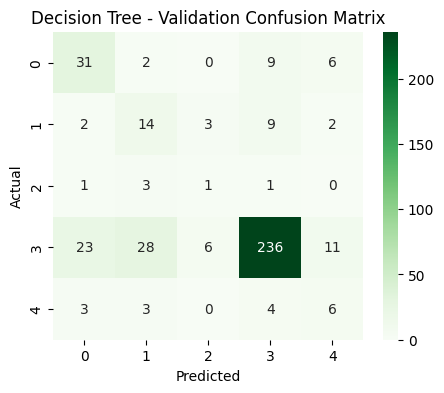


Decision Tree - Test accuracy: 0.7051
Classification report (test):
               precision    recall  f1-score   support

           0       0.54      0.65      0.59        95
           1       0.24      0.37      0.29        60
           2       0.12      0.17      0.14        12
           3       0.88      0.77      0.82       607
           4       0.31      0.48      0.38        33

    accuracy                           0.71       807
   macro avg       0.42      0.49      0.44       807
weighted avg       0.76      0.71      0.73       807



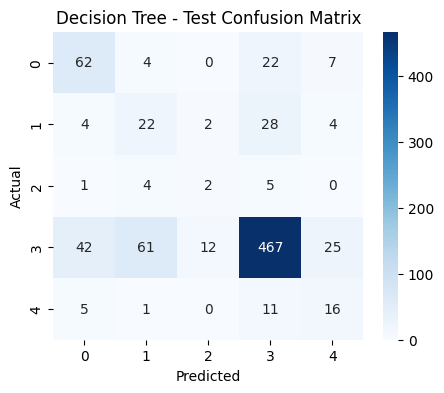

In [55]:
# For US data
results_store_us['Decision Tree'] = run_dt_workflow(prep_us)




Best DT params: {'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'gini'}

Decision Tree - Validation accuracy: 0.5946
Classification report (validation):
               precision    recall  f1-score   support

           0       0.04      0.23      0.06       142
           1       0.79      0.71      0.74      7119
           2       0.21      0.21      0.21      1931

    accuracy                           0.59      9192
   macro avg       0.34      0.38      0.34      9192
weighted avg       0.65      0.59      0.62      9192



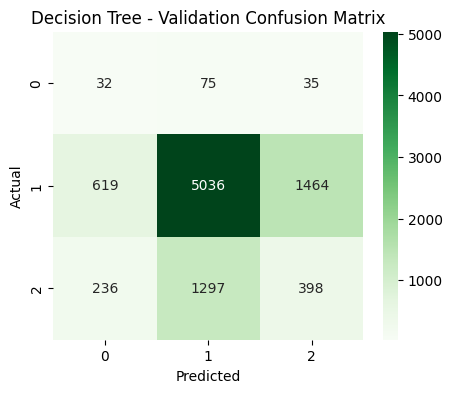


Decision Tree - Test accuracy: 0.5993
Classification report (test):
               precision    recall  f1-score   support

           0       0.05      0.30      0.08       283
           1       0.79      0.71      0.75     14238
           2       0.22      0.22      0.22      3862

    accuracy                           0.60     18383
   macro avg       0.35      0.41      0.35     18383
weighted avg       0.66      0.60      0.63     18383



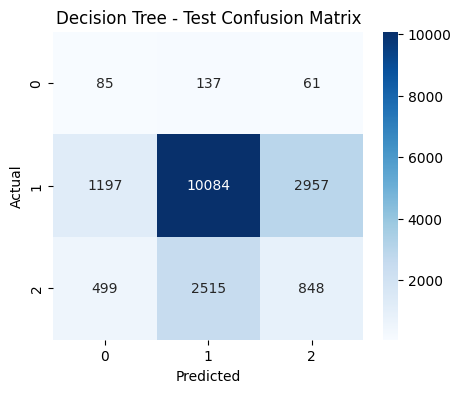

In [56]:

# For US data
results_store_uk['Decision Tree'] = run_dt_workflow(prep_uk)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

def run_rf_workflow(prep):
    rf = RandomForestClassifier(random_state=RANDOM_STATE)
    rf_search = RandomizedSearchCV(
        rf,
        param_grids['Random Forest'],  # Make sure this param grid is defined for RF
        n_iter=5,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    rf_search.fit(prep['X_train'], prep['y_train'])
    print("Best RF params:", rf_search.best_params_)
    best_rf = rf_search.best_estimator_

    rf_metrics = evaluate_and_store(
        'Random Forest',
        best_rf,
        prep['X_train'], prep['X_test'],
        prep['y_train'], prep['y_test'],
        X_val=prep.get('X_val'), y_val=prep.get('y_val')  # include validation data
    )
    return rf_metrics


Best RF params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

Random Forest - Validation accuracy: 0.8069
Classification report (validation):
               precision    recall  f1-score   support

           0       0.60      0.73      0.66        48
           1       0.52      0.53      0.52        30
           2       0.50      0.17      0.25         6
           3       0.89      0.89      0.89       304
           4       0.33      0.19      0.24        16

    accuracy                           0.81       404
   macro avg       0.57      0.50      0.51       404
weighted avg       0.80      0.81      0.80       404



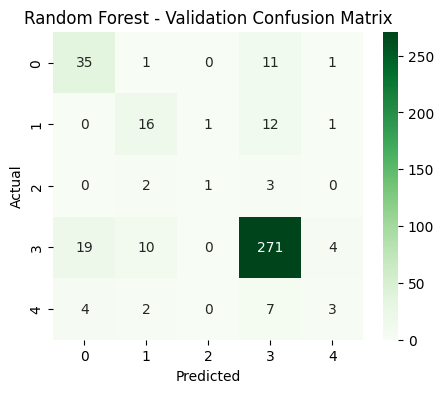


Random Forest - Test accuracy: 0.7993
Classification report (test):
               precision    recall  f1-score   support

           0       0.62      0.84      0.71        95
           1       0.39      0.38      0.39        60
           2       0.60      0.25      0.35        12
           3       0.89      0.87      0.88       607
           4       0.57      0.24      0.34        33

    accuracy                           0.80       807
   macro avg       0.61      0.52      0.53       807
weighted avg       0.80      0.80      0.79       807



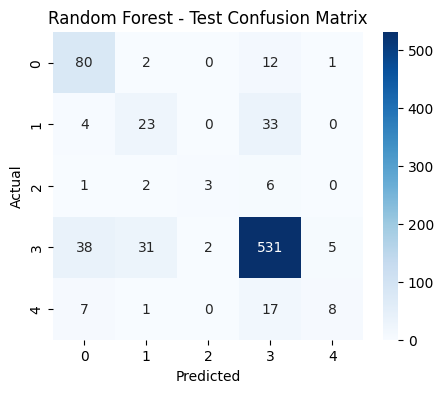

In [58]:
results_store_us['Random Forest'] = run_rf_workflow(prep_us)  # for US data


Best RF params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

Random Forest - Validation accuracy: 0.7065
Classification report (validation):
               precision    recall  f1-score   support

           0       0.06      0.05      0.05       142
           1       0.79      0.86      0.82      7119
           2       0.27      0.18      0.21      1931

    accuracy                           0.71      9192
   macro avg       0.37      0.36      0.36      9192
weighted avg       0.67      0.71      0.68      9192



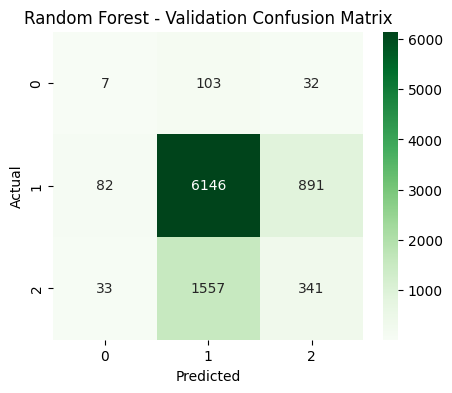


Random Forest - Test accuracy: 0.7014
Classification report (test):
               precision    recall  f1-score   support

           0       0.06      0.05      0.05       283
           1       0.79      0.86      0.82     14238
           2       0.26      0.18      0.21      3862

    accuracy                           0.70     18383
   macro avg       0.37      0.36      0.36     18383
weighted avg       0.66      0.70      0.68     18383



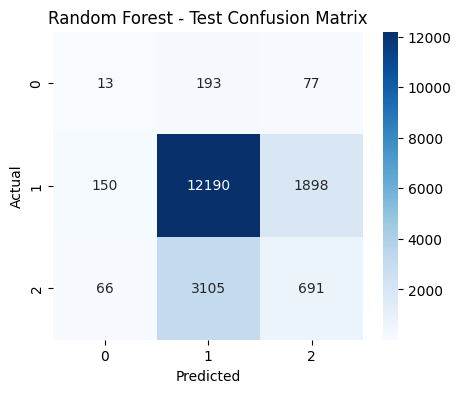

In [59]:
results_store_uk['Random Forest'] =  run_rf_workflow(prep_uk)  # for UK data


In [60]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

def run_xgb_workflow(prep):
    xgb = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
    xgb_search = RandomizedSearchCV(
        xgb,
        param_grids['XGBoost'],
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    xgb_search.fit(prep['X_train'], prep['y_train'])
    print("Best XGB params:", xgb_search.best_params_)
    best_xgb = xgb_search.best_estimator_

    xgb_metrics = evaluate_and_store(
        'XGBoost',
        best_xgb,
        prep['X_train'], prep['X_test'],
        prep['y_train'], prep['y_test'],
        X_val=prep.get('X_val'), y_val=prep.get('y_val')  # pass validation set here
    )
    return xgb_metrics


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:41:35] WARN

Best XGB params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

XGBoost - Validation accuracy: 0.8119
Classification report (validation):
               precision    recall  f1-score   support

           0       0.62      0.69      0.65        48
           1       0.50      0.50      0.50        30
           2       0.33      0.33      0.33         6
           3       0.90      0.90      0.90       304
           4       0.40      0.25      0.31        16

    accuracy                           0.81       404
   macro avg       0.55      0.53      0.54       404
weighted avg       0.81      0.81      0.81       404



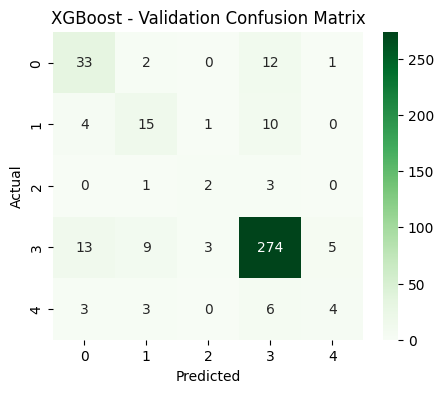


XGBoost - Test accuracy: 0.8178
Classification report (test):
               precision    recall  f1-score   support

           0       0.69      0.85      0.76        95
           1       0.36      0.35      0.36        60
           2       0.50      0.25      0.33        12
           3       0.89      0.89      0.89       607
           4       0.63      0.36      0.46        33

    accuracy                           0.82       807
   macro avg       0.62      0.54      0.56       807
weighted avg       0.81      0.82      0.81       807



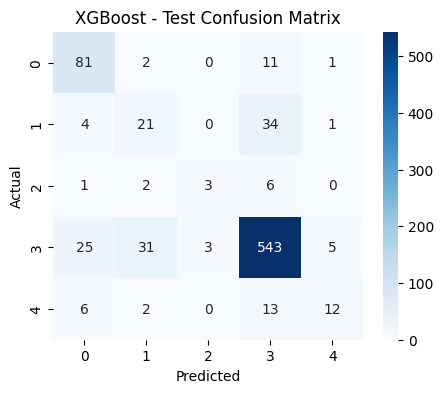

In [61]:

results_store_us['XGBoost'] =  run_xgb_workflow(prep_us)  # for US data


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:41:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:41:46] WARN

Best XGB params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}

XGBoost - Validation accuracy: 0.6820
Classification report (validation):
               precision    recall  f1-score   support

           0       0.05      0.12      0.07       142
           1       0.79      0.83      0.81      7119
           2       0.25      0.17      0.20      1931

    accuracy                           0.68      9192
   macro avg       0.36      0.37      0.36      9192
weighted avg       0.66      0.68      0.67      9192



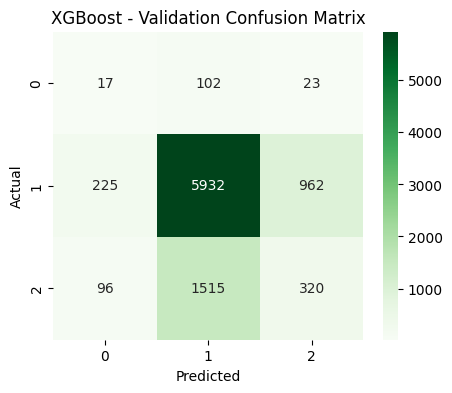


XGBoost - Test accuracy: 0.6813
Classification report (test):
               precision    recall  f1-score   support

           0       0.05      0.12      0.07       283
           1       0.79      0.83      0.81     14238
           2       0.25      0.17      0.20      3862

    accuracy                           0.68     18383
   macro avg       0.36      0.38      0.36     18383
weighted avg       0.66      0.68      0.67     18383



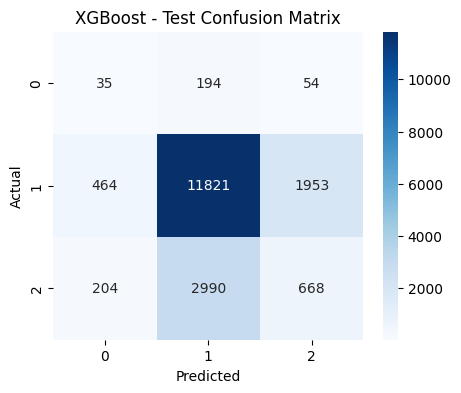

In [62]:
results_store_uk['XGBoost'] = run_xgb_workflow(prep_uk)  # for UK data

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

def run_lr_workflow(prep):
    lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=2000)
    lr_search = RandomizedSearchCV(
        lr,
        param_grids['Logistic Regression'],
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    lr_search.fit(prep['X_train_scaled'], prep['y_train'])

    print("Best LR params:", lr_search.best_params_)
    best_lr = lr_search.best_estimator_

    lr_metrics = evaluate_and_store(
        'Logistic Regression',
        best_lr,
        prep['X_train_scaled'], prep['X_test_scaled'],
        prep['y_train'], prep['y_test'],
        X_val=prep.get('X_val_scaled'), y_val=prep.get('y_val')  # include validation if available
    )
    return lr_metrics


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skle

Best LR params: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C': 0.01}

Logistic Regression - Validation accuracy: 0.4828
Classification report (validation):
               precision    recall  f1-score   support

           0       0.04      0.47      0.07       142
           1       0.80      0.53      0.64      7119
           2       0.21      0.29      0.24      1931

    accuracy                           0.48      9192
   macro avg       0.35      0.43      0.32      9192
weighted avg       0.66      0.48      0.55      9192



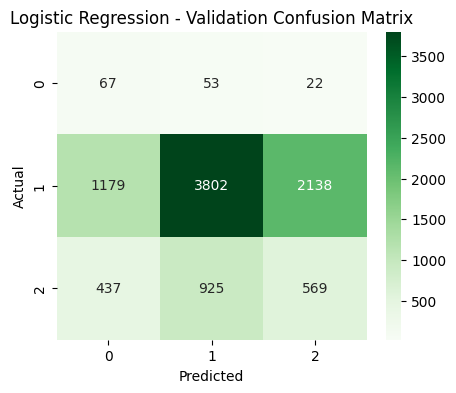


Logistic Regression - Test accuracy: 0.4783
Classification report (test):
               precision    recall  f1-score   support

           0       0.04      0.42      0.07       283
           1       0.79      0.53      0.63     14238
           2       0.21      0.29      0.24      3862

    accuracy                           0.48     18383
   macro avg       0.34      0.42      0.31     18383
weighted avg       0.66      0.48      0.54     18383



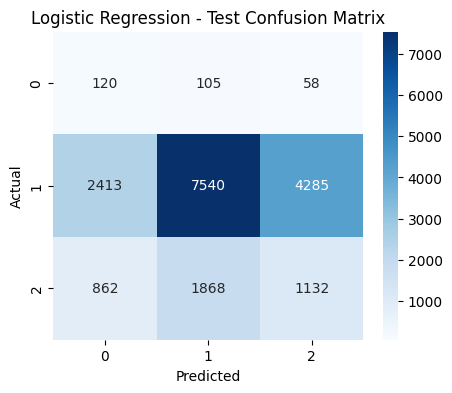

In [64]:
results_store_uk['Logistic Regression'] = run_lr_workflow(prep_uk)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skle

Best LR params: {'solver': 'saga', 'penalty': 'l2', 'l1_ratio': 0.5, 'C': 1}

Logistic Regression - Validation accuracy: 0.4901
Classification report (validation):
               precision    recall  f1-score   support

           0       0.43      0.54      0.48        48
           1       0.22      0.33      0.26        30
           2       0.02      0.17      0.03         6
           3       0.83      0.51      0.63       304
           4       0.14      0.38      0.20        16

    accuracy                           0.49       404
   macro avg       0.32      0.39      0.32       404
weighted avg       0.70      0.49      0.56       404



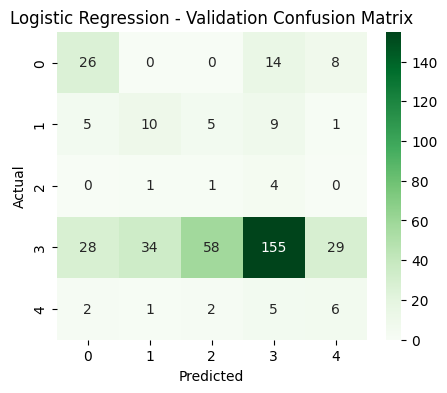


Logistic Regression - Test accuracy: 0.4758
Classification report (test):
               precision    recall  f1-score   support

           0       0.37      0.53      0.43        95
           1       0.19      0.40      0.26        60
           2       0.03      0.33      0.06        12
           3       0.88      0.48      0.62       607
           4       0.15      0.39      0.21        33

    accuracy                           0.48       807
   macro avg       0.32      0.43      0.32       807
weighted avg       0.73      0.48      0.55       807



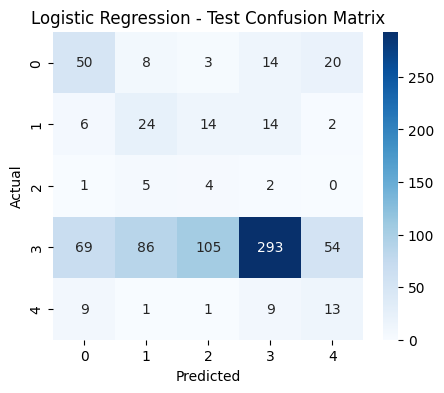

In [65]:
results_store_us['Logistic Regression'] = run_lr_workflow(prep_us)

In [66]:
def summarize_and_plot_results(results_store, dataset_label=''):
    summary_rows = []
    for name, m in results_store.items():
        row = {
            'Model': name,
            'Train Accuracy': m['train_accuracy'],
            'Test Accuracy': m['test_accuracy'],
            'Test Precision': m['test_precision'],
            'Test Recall': m['test_recall'],
            'Test F1': m['test_f1'],
            'Overfit (train-test)': m['train_accuracy'] - m['test_accuracy']
        }
        # Add validation metrics if available
        if 'val_accuracy' in m:
            row.update({
                'Val Accuracy': m['val_accuracy'],
                'Val Precision': m.get('val_precision', None),
                'Val Recall': m.get('val_recall', None),
                'Val F1': m.get('val_f1', None)
            })
        summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows).sort_values('Test Accuracy', ascending=False)
    print(f"Summary for {dataset_label} dataset:")
    display(summary_df)

    plt.figure(figsize=(8,4))
    sns.barplot(x='Model', y='Test Accuracy', data=summary_df)
    plt.xticks(rotation=45)
    plt.ylim(0,1)
    plt.title(f"Model test accuracy comparison ({dataset_label})")
    plt.show()

    return summary_df



Summary for UK dataset:


Model  Train Accuracy  Test Accuracy  Test Precision  \
1        Random Forest        1.000000       0.701409        0.664920   
2              XGBoost        0.780170       0.681282        0.663399   
0        Decision Tree        0.669443       0.599304        0.660059   
3  Logistic Regression        0.556381       0.478268        0.657865   

   Test Recall   Test F1  Overfit (train-test)  Val Accuracy  Val Precision  \
1     0.701409  0.680486              0.298591      0.706484       0.667340   
2     0.681282  0.670203              0.098889      0.682006       0.660874   
0     0.599304  0.626469              0.070139      0.594648       0.653288   
3     0.478268  0.543704              0.078113      0.482811       0.660433   

   Val Recall    Val F1  
1    0.706484  0.683509  
2    0.682006  0.669067  
0    0.594648  0.621308  
3    0.482811  0.547362

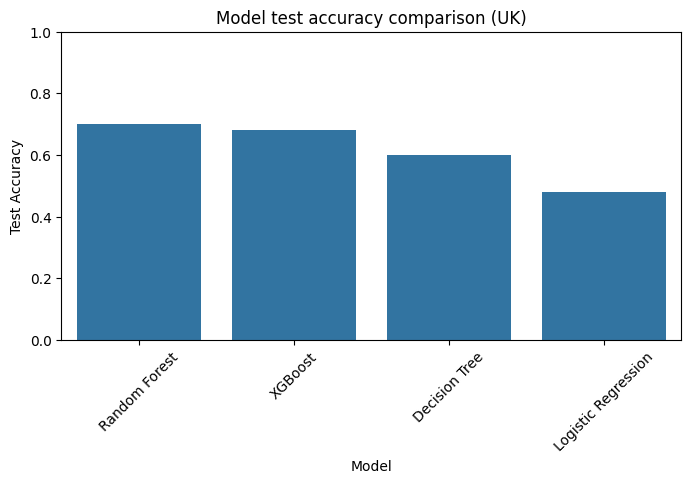

In [67]:
summary_uk = summarize_and_plot_results(results_store_uk, dataset_label='UK')


Summary for US dataset:


Model  Train Accuracy  Test Accuracy  Test Precision  \
2              XGBoost        0.990579       0.817844        0.814542   
1        Random Forest        0.999906       0.799257        0.800496   
0        Decision Tree        0.851060       0.705081        0.755273   
3  Logistic Regression        0.574282       0.475836        0.728243   

   Test Recall   Test F1  Overfit (train-test)  Val Accuracy  Val Precision  \
2     0.817844  0.813112              0.172736      0.811881       0.807892   
1     0.799257  0.793978              0.200649      0.806931       0.801442   
0     0.705081  0.725135              0.145979      0.712871       0.778821   
3     0.475836  0.549553              0.098445      0.490099       0.696119   

   Val Recall    Val F1  
2    0.811881  0.809009  
1    0.806931  0.801425  
0    0.712871  0.738494  
3    0.490099  0.559642

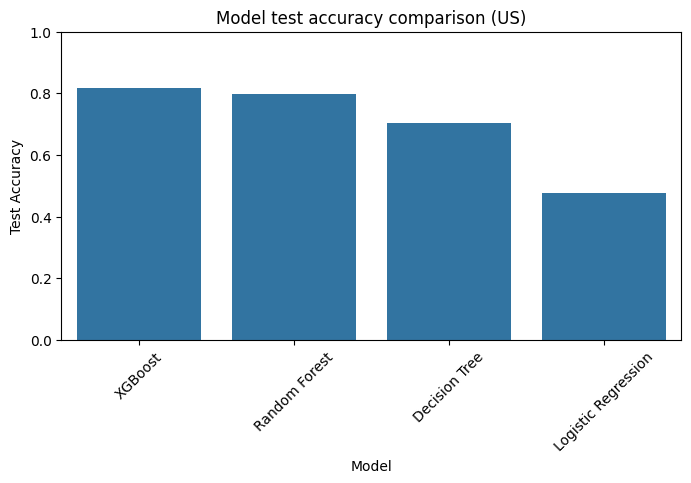

In [68]:
summary_us = summarize_and_plot_results(results_store_us, dataset_label='US')


In [69]:
import shap

def run_shap_rf(results_store, prep, dataset_label=''):
    try:
        model = results_store['Random Forest']['model']
        Xs = prep['X_test'].iloc[:200]  # limit for speed

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(Xs)

        print(f"SHAP summary plots for Random Forest on {dataset_label} dataset:")

        # Handle multiclass vs binary output
        if isinstance(shap_values, list):
            # For multiclass, by default show class 1 (adjust index if needed)
            class_idx = 1 if len(shap_values) > 1 else 0
            shap.summary_plot(shap_values[class_idx], Xs, feature_names=prep['feature_names'])
            shap.summary_plot(shap_values[class_idx], Xs, plot_type="bar", feature_names=prep['feature_names'])
        else:
            shap.summary_plot(shap_values, Xs, feature_names=prep['feature_names'])
            shap.summary_plot(shap_values, Xs, plot_type="bar", feature_names=prep['feature_names'])

    except Exception as e:
        print(f"SHAP error for {dataset_label}:", e)




SHAP summary plots for Random Forest on US dataset:


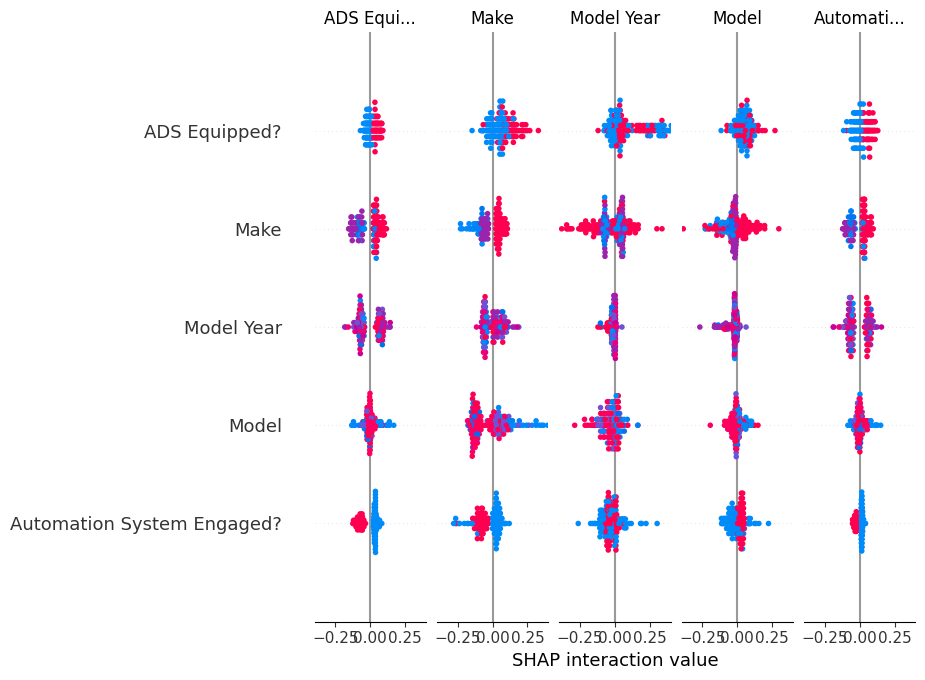

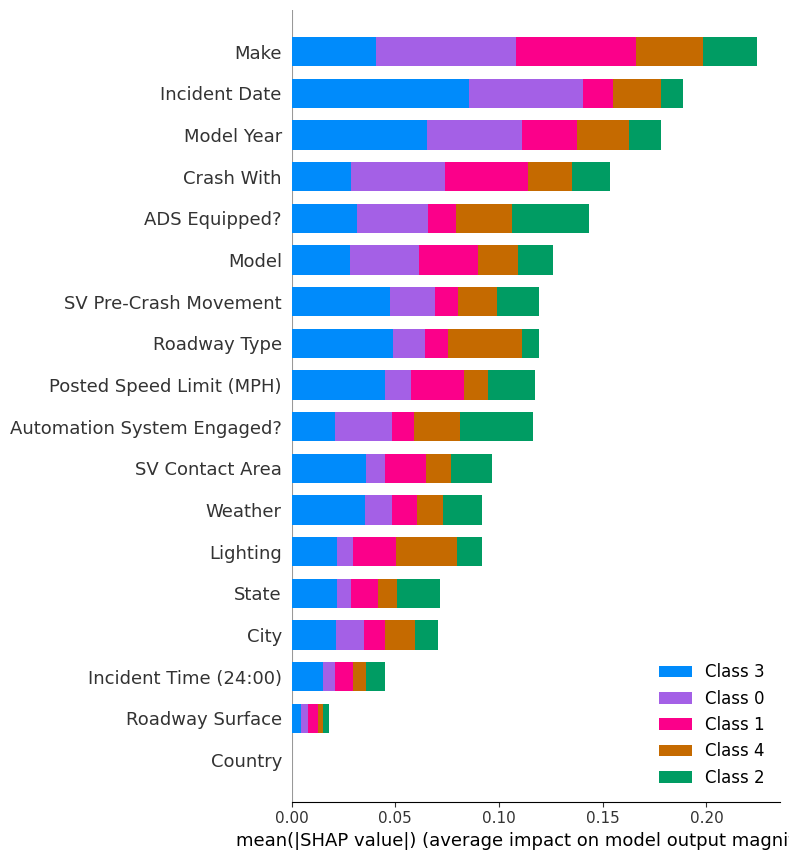

In [70]:

run_shap_rf(results_store_us, prep_us, dataset_label='US')


SHAP summary plots for Random Forest on UK dataset:


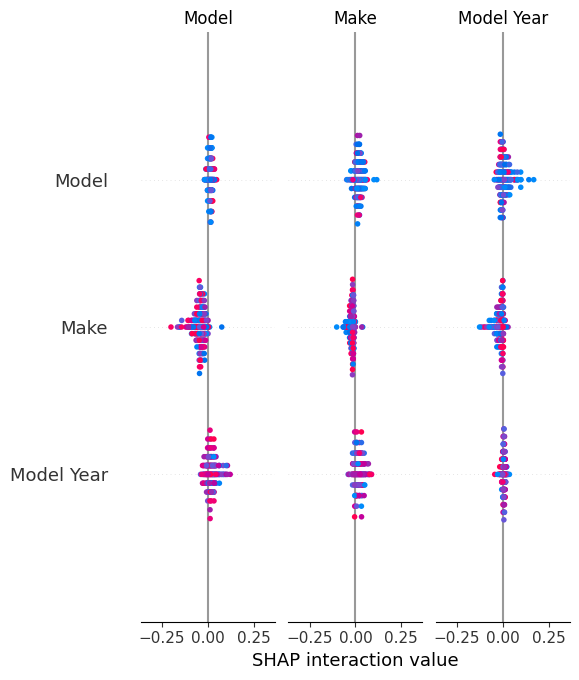

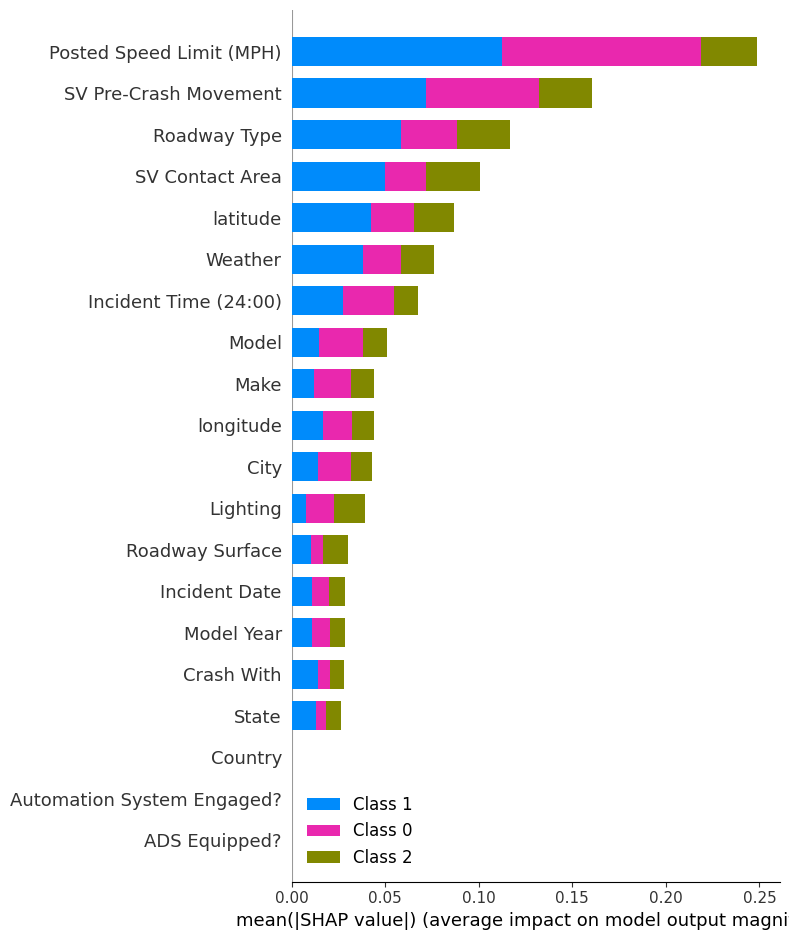

In [71]:
run_shap_rf(results_store_uk, prep_uk, dataset_label='UK')

In [72]:
import lime.lime_tabular

def run_lime_rf_explanation(results_store, prep, dataset_label=''):
    try:
        model = results_store['Random Forest']['model']

        # Determine class names from label encoder or from unique targets
        if prep.get('label_encoder') is not None:
            class_names = list(prep['label_encoder'].classes_)
        else:
            class_names = [str(c) for c in sorted(prep['y_train'].unique())]

        explainer = lime.lime_tabular.LimeTabularExplainer(
            prep['X_train'].values,
            feature_names=prep['feature_names'],
            class_names=class_names,
            discretize_continuous=True,
            mode='classification'  # explicitly specify classification mode
        )

        idx = 0  # index of test instance to explain, can be parameterized
        instance = prep['X_test'].iloc[idx].values

        explanation = explainer.explain_instance(instance, model.predict_proba, num_features=10)
        print(f"LIME explanation for Random Forest on {dataset_label} dataset, instance {idx}:")

        # Display in notebook or print text explanation as fallback
        try:
            explanation.show_in_notebook(show_table=True)
        except Exception:
            print(explanation.as_list())

    except Exception as e:
        print(f"LIME error for {dataset_label} dataset:", e)




In [73]:

run_lime_rf_explanation(results_store_us, prep_us, dataset_label='US')


LIME explanation for Random Forest on US dataset, instance 0:


In [74]:
run_lime_rf_explanation(results_store_uk, prep_uk, dataset_label='UK')

LIME explanation for Random Forest on UK dataset, instance 0:
